 Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import json
import os
import pickle
import random
import time

# Ignore warnings
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from skimage import io, transform
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch dataset
from torchvision import datasets, models, transforms, utils
from torchvision.utils import make_grid

warnings.filterwarnings("ignore")

plt.ion()  # interactive mode

from __future__ import print_function, division

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


 Define helper functions

In [ ]:
def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()



In [ ]:
def show_images(image):
    """Show image"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

## 3. Define OcularDiseaseRecognition class

In [ ]:
class OcularDiseaseRecognition(Dataset):
    """Ocular Disease Recognition."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels_frame.iloc[idx, 1])
        image = io.imread(img_name)
        target = self.labels_frame.iloc[idx, 3]
        target = np.array(json.loads(target))
        sample = {'image': image, 'labels': target}

        if self.transform:
            sample = self.transform(sample)

        return sample

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'labels': label}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]


        return {'image': image, 'labels': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['labels']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(label)}

Define Pytorch **Dataloader** & Load Data

Load Labels

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Dataset/Ocular_disease_Analysis/labels_clean.csv')

n = 65
img_name = labels.iloc[n, 1]
class_name =  labels.iloc[n, 2]
target = labels.iloc[n, 3]

print('Image name: {}'.format(img_name))
print('Class Name: {}'.format(class_name))
print('Target: {}'.format(target))

Image name: 81_right.jpg
Class Name: Diabetes
Target: [0, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
labels.head(2)

,ID,filename,class_name,target
0,0,0_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"
1,1,1_right.jpg,Normal,"[1, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
labels.shape

(6392, 4)

### 4.2 Load Image Data

In [ ]:
# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2
test_size = 0.2

In [ ]:
# choose the training and test datasets
img_dir = "/content/drive/MyDrive/Dataset/Ocular_disease_Analysis/preprocessed_images"
labels_dir = '/content/drive/MyDrive/Dataset/Ocular_disease_Analysis/labels_clean.csv'

full_data  = OcularDiseaseRecognition(csv_file=labels_dir,
                                      root_dir=img_dir,
                                      transform=transforms.Compose([Rescale(512),
                                                                    ToTensor()])
                                     )

In [ ]:
# obtain training indices that will be used for validation
num_train = len(full_data)
indices = list(range(num_train))

np.random.shuffle(indices)

val_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(valid_size * num_train))


test_idx, valid_idx, train_idx = indices[:test_split], indices[test_split: test_split + val_split], indices[test_split + val_split:]

In [ ]:
num_train

6392

In [ ]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler  = SubsetRandomSampler(test_idx)

In [ ]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(full_data, batch_size=batch_size,
    sampler=test_sampler, num_workers=num_workers)

In [ ]:
len(train_loader)

120

### 4.3 Visualize a Batch of Training Data

In [ ]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
sample = next(dataiter)

sample['image'].shape # (number of examples: 20, number of channels: 3, pixel sizes: 256x256)

torch.Size([32, 3, 512, 512])

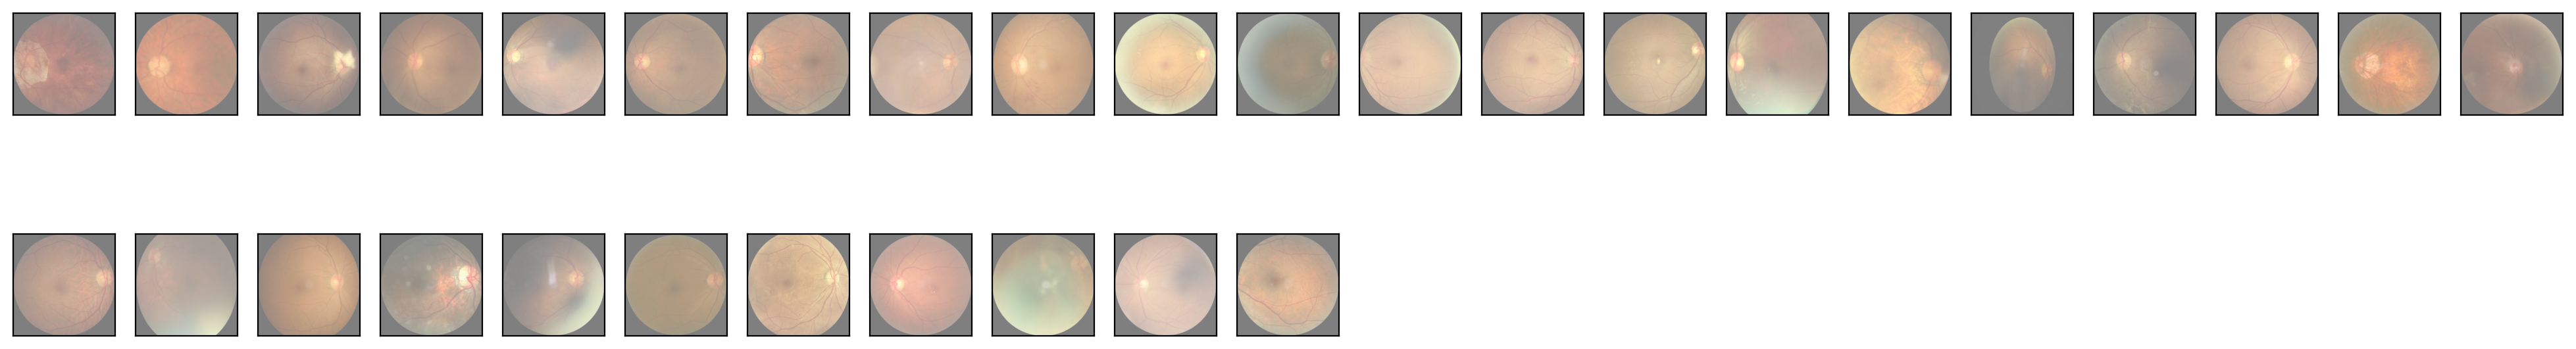

In [ ]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 21, idx+1, xticks=[], yticks=[])
    imshow(sample['image'][idx])

## 5. Model Training

In [ ]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

print(device_name)

cuda


In [ ]:
def save_checkpoint(state, is_best, filename='/content/drive/MyDrive/Dataset/Ocular_disease_Analysis/nvidia_resnet50_200821.pth'):
    torch.save(state, filename)

### 5.1 Define Model Achitecture

In [ ]:
# instantiate transfer learning model
resnet_model = models.resnet50(pretrained=True)

# set all parameters as trainable
for param in resnet_model.parameters():
    param.requires_grad = True

# get input of fc layer
n_inputs = resnet_model.fc.in_features

# redefine fc layer / top layer/ head for our classification problem
resnet_model.fc = nn.Sequential(nn.Linear(n_inputs, 2048),
                                nn.ReLU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.ReLU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 8),
                                nn.LogSigmoid())

# set all parameters of the model as trainable
for name, child in resnet_model.named_children():
    for name2, params in child.named_parameters():
        params.requires_grad = True

resnet_model1=resnet_model
# Disbribute the model to all GPU's
resnet_model = nn.DataParallel(resnet_model)

# set model to run on GPU or CPU absed on availibility
resnet_model.to(device)

# print the trasnfer learning NN model's architecture
resnet_model


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
total_params = sum(p.numel() for p in resnet_model.parameters())

In [ ]:
total_params

31917128

In [ ]:
from torchsummary import summary

model = resnet_model1
print(summary(model, (3,512 ,512 )))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

### 5.2 Define `Criterion` & `Optimizer`

In [ ]:
# loss function
# if GPU is available set loss function to use GPU
criterion = nn.CrossEntropyLoss().to(device)

# optimizer
optimizer = torch.optim.SGD(resnet_model.parameters(), momentum=0.9, lr=3e-4)


# empty lists to store losses and accuracies
train_losses = []
test_losses = []
train_correct = []
test_correct = []

[link text](https://)### 5.3 Run the Traing Loop

In [ ]:
# number of training iterations
epochs = 3

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# set training start time
start_time = time.time()

# set best_prec loss value as 2 for checkpoint threshold
best_prec1 = 2
is_best = False

# empty batch variables
b = None
train_b = None
test_b = None

scaler = GradScaler()

for i in range(epochs):
    # empty training correct and test correct counter as 0 during every iteration
    trn_corr = 0
    tst_corr = 0
    trn_loss = 0
    tst_loss = 0

    # set epoch's starting time
    e_start = time.time()


    # train in batches
    for b, sample in enumerate(train_loader):
        # set label as cuda if device is cuda
        X, y = sample['image'].to(device, dtype=torch.float), sample['labels'].to(device, dtype=torch.float)

        # forward pass image sample
        y_pred = resnet_model(X.view(-1, 3, 512, 512))

        # calculate loss
        loss = criterion(y_pred.float(), y.float())

        trn_loss += loss.item()
        # get argmax of predicted tensor, which is our label
        predicted = torch.argmax(y_pred, dim=1).data
        y = torch.argmax(y, dim=1).data

        # if predicted label is correct as true label, calculate the sum for samples

        batch_corr = (predicted == y).sum()
        # increment train correct with correcly predicted labels per batch
        trn_corr += batch_corr.item()

        # set optimizer gradients to zero
        optimizer.zero_grad()
        # Backpropagate with autocasting
        # back propagate with loss
        scaler.scale(loss).backward()
        # perform optimizer step
        scaler.step(optimizer)
        scaler.update()

    # set epoch's end time
    e_end = time.time()

    # print training metrics
    print(f'Epoch {(i+1)} Batch {(b+1)}\nAccuracy: {trn_corr*100/(b*batch_size):2.2f} %  Loss: {trn_loss/len(train_loader):2.4f}  Duration: {((e_end-e_start)/60):.2f} minutes')

    # some metrics storage for visualization
    train_b = b
    train_losses.append(trn_loss)
    train_correct.append(trn_corr)

    X, y = None, None

    # validate using validation generator
    # do not perform any gradient updates while validation
    with torch.no_grad():
        for b, sample in enumerate(valid_loader):
            # set label as cuda if device is cuda
            X, y = sample['image'].to(device, dtype=torch.float), sample['labels'].to(device, dtype=torch.float)

            # forward pass image
            y_val = resnet_model(X.view(-1, 3, 512, 512))

            # get argmax of predicted tensor, which is our label
            predicted = torch.argmax(y_val, dim=1).data
            y = torch.argmax(y, dim=1).data

            # increment test correct with correcly predicted labels per batch
            tst_corr += (predicted == y).sum().item()

            # get loss of validation set
            loss = criterion(y_val.float(), y.long())
            tst_loss += loss.item()


    # print validation metrics
    print(f'Validation Accuracy {tst_corr*100/(b*batch_size):2.2f}% Validation Loss: {tst_loss/len(valid_loader):2.4f}\n')

    # if current validation loss is less than previous iteration's validatin loss create and save a checkpoint
    is_best = loss < best_prec1
    best_prec1 = min(loss, best_prec1)

    if is_best:
        save_checkpoint({
                'epoch': i + 1,
                'state_dict': resnet_model.state_dict(),
                'best_prec1': best_prec1,
            }, is_best)

        is_best = False

    # some metrics storage for visualization
    test_b  = b
    test_losses.append(tst_loss)
    test_correct.append(tst_corr)

# set total training's end time
end_time = time.time() - start_time

# print training summary
print("\nTraining Duration {:.2f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1 Batch 120
Accuracy: 41.44 %  Loss: 1.9363  Duration: 6.21 minutes
Validation Accuracy 47.04% Validation Loss: 1.7810

Epoch 2 Batch 120
Accuracy: 44.72 %  Loss: 1.6754  Duration: 6.06 minutes
Validation Accuracy 47.04% Validation Loss: 1.5640

Epoch 3 Batch 120
Accuracy: 44.72 %  Loss: 1.5573  Duration: 5.71 minutes
Validation Accuracy 47.04% Validation Loss: 1.5054

Epoch 4 Batch 120
Accuracy: 44.72 %  Loss: 1.5207  Duration: 5.69 minutes
Validation Accuracy 47.04% Validation Loss: 1.4751

Epoch 5 Batch 120
Accuracy: 44.72 %  Loss: 1.5002  Duration: 5.62 minutes
Validation Accuracy 47.04% Validation Loss: 1.4580

Epoch 6 Batch 120
Accuracy: 44.72 %  Loss: 1.4870  Duration: 5.59 minutes
Validation Accuracy 47.04% Validation Loss: 1.4410

Epoch 7 Batch 120
Accuracy: 44.72 %  Loss: 1.4729  Duration: 5.64 minutes
Validation Accuracy 47.04% Validation Loss: 1.4317

Epoch 8 Batch 120
Accuracy: 44.72 %  Loss: 1.4625  Duration: 5.60 minutes
Validation Accuracy 47.04% Validation Loss: 

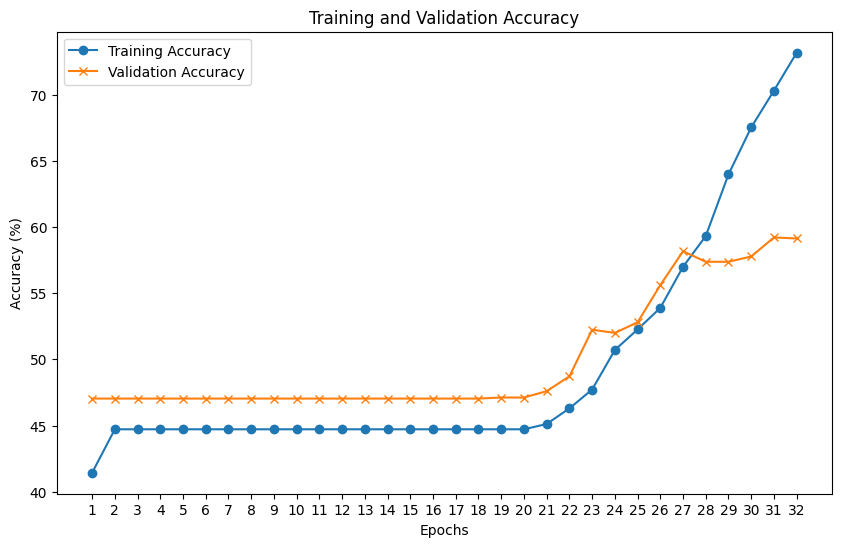

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 33))  # Assuming there are 32 epochs

accuracy_values = [
    41.44, 44.72, 44.72, 44.72, 44.72, 44.72, 44.72, 44.72, 44.72, 44.72,
    44.72, 44.72, 44.72, 44.72, 44.72, 44.72, 44.72, 44.72, 44.72, 44.72,
    45.12, 46.30, 47.72, 50.71, 52.26, 53.89, 56.99, 59.32, 63.97, 67.52,
    70.30, 73.16
]

validation_accuracy_values = [
    47.04, 47.04, 47.04, 47.04, 47.04, 47.04, 47.04, 47.04, 47.04, 47.04,
    47.04, 47.04, 47.04, 47.04, 47.04, 47.04, 47.04, 47.04, 47.12, 47.12,
    47.60, 48.72, 52.24, 52.00, 52.80, 55.61, 58.17, 57.37, 57.37, 57.77,
    59.21, 59.13
]

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy_values, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy_values, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()


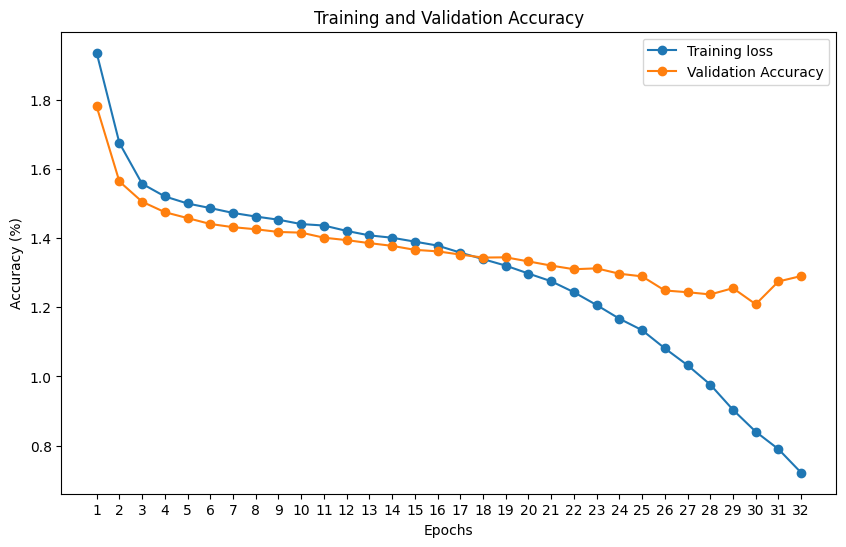

In [ ]:
import matplotlib.pyplot as plt

# Extracted loss and validation loss values
loss_values = [
    1.9363, 1.6754, 1.5573, 1.5207, 1.5002, 1.4870, 1.4729, 1.4625, 1.4533, 1.4407,
    1.4365, 1.4209, 1.4080, 1.4012, 1.3899, 1.3785, 1.3582, 1.3394, 1.3205, 1.2976,
    1.2753, 1.2436, 1.2065, 1.1670, 1.1338, 1.0813, 1.0325, 0.9765, 0.9035, 0.8402,
    0.7897, 0.7215
]

val_loss_values = [
    1.7810, 1.5640, 1.5054, 1.4751, 1.4580, 1.4410, 1.4317, 1.4257, 1.4179, 1.4159,
    1.4013, 1.3943, 1.3856, 1.3777, 1.3662, 1.3618, 1.3525, 1.3438, 1.3445, 1.3327,
    1.3206, 1.3101, 1.3126, 1.2971, 1.2894, 1.2486, 1.2436, 1.2372, 1.2553, 1.2088,
    1.2747, 1.2904
]


plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, label='Training loss', marker='o')
plt.plot(epochs, val_loss_values, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()